In [1]:
import sys
sys.path.append('../src/')

import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import pymc3 as pm
import arviz as az
import theano
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter, PercentFormatter

from utils.data_utils import load_data, standardize_area, map_zip_codes
from utils.plot_utils import set_plot_defaults, plot_pred_hist

/home/corrie/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
set_plot_defaults("Europace Sans")
d, zip_lookup, num_zip_codes = load_data(kind="prices")   # loads data from data/interim_data/houses.csv 
                                                          # aternatively, use kind="rents" to load data from data/interim_data/rent.csv
zip_codes = np.sort(d.zip.unique())
target = "price_s"

In [3]:
data = az.from_netcdf("../models/centered_hier.nc")
data

Inference data with groups:
	> posterior
	> sample_stats
	> posterior_predictive
	> prior
	> observed_data
	> constant_data

In [4]:
zips = theano.shared(d["zip_code"].values)
# idx variables cannnot used with pm.Data() so far, because of bug
# see here: https://discourse.pymc.io/t/integer-values-with-pm-data/3776
# and here: https://github.com/pymc-devs/pymc3/issues/3493

with pm.Model() as centered_hier_model:
    area = pm.Data("area", d["living_space_s"])
    #zips = pm.Data("zips", d["zip_code"].values)
    
    mu_alpha = pm.Normal("mu_alpha", mu=0, sd=20)
    sigma_alpha = pm.Exponential("sigma_alpha", lam=1/5)
    
    mu_beta = pm.Normal("mu_beta", mu=0, sd=5)
    sigma_beta = pm.Exponential("sigma_beta", lam=1/5)
    
    alpha = pm.Normal("alpha", mu=mu_alpha, sd=sigma_alpha, shape=num_zip_codes)
    beta = pm.Normal("beta", mu=mu_beta, sd=sigma_beta, shape=num_zip_codes)
    # without varying sigma
    sigma = pm.Exponential("sigma", lam=1/5)
    
    mu = alpha[zips] + beta[zips]*area
    y = pm.Normal("y", mu=mu, sd=sigma, observed=d[target])
    
    trace = pm.load_trace("../models/centered_hier/")

In [5]:
more_houses = pd.DataFrame({"area": standardize_area(np.array([100, 240, 74]), d=d), "zip_code": ["10243", "10179", "12047"]})

In [6]:
more_houses["zip"] = map_zip_codes(more_houses["zip_code"])

In [7]:
with centered_hier_model:
    zips.set_value(more_houses["zip"])
    pm.set_data({"area": more_houses["area"]})
    post_pred = pm.sample_posterior_predictive(trace, samples=1000)

100%|██████████| 1000/1000 [00:01<00:00, 582.72it/s]


In [8]:
post_pred["y"].shape

(1000, 3)

In [9]:
y_pred = post_pred["y"][:,0]*100000

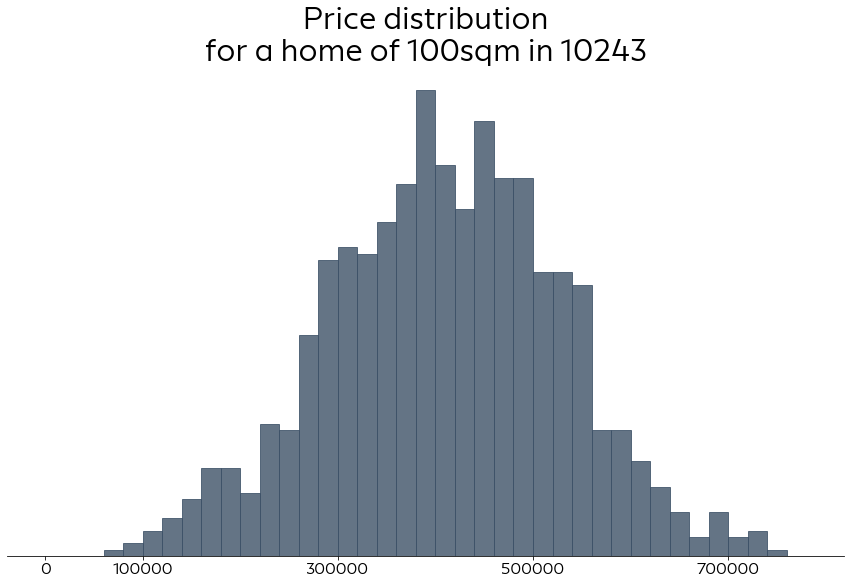

In [10]:
plot_pred_hist(y_pred, title="Price distribution\nfor a home of 100sqm in 10243")
plt.show()

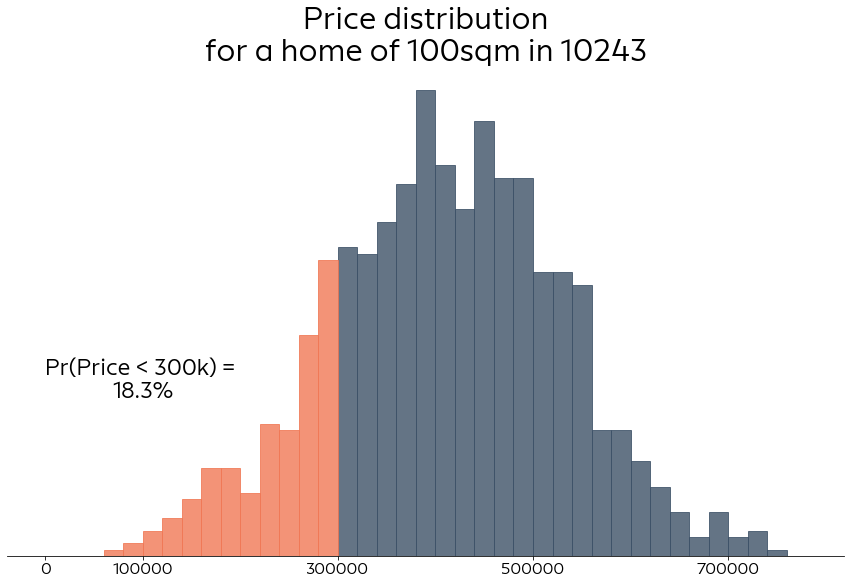

In [11]:
plot_pred_hist(y_pred, threshold=300000, title="Price distribution\nfor a home of 100sqm in 10243")
plt.show()

In [12]:
zip_shapes = gpd.read_file('../data/shapefiles/plz-gebiete/plz-gebiete.shp')
berlin_shapes = zip_shapes[zip_shapes.note.str.contains("Berlin")]

In [13]:
zip_median = data.posterior.stack(samples=["draw", "chain"]).reset_index("samples")["alpha"].groupby("zip_code").median(dim="samples").to_dataframe()

In [14]:
berlin_shapes = berlin_shapes.join(zip_median, on="plz")

In [15]:
berlin_shapes = berlin_shapes.to_crs({'init': 'epsg:3395'})

In [16]:
berlin_shapes["alpha"] = berlin_shapes["alpha"] * 100

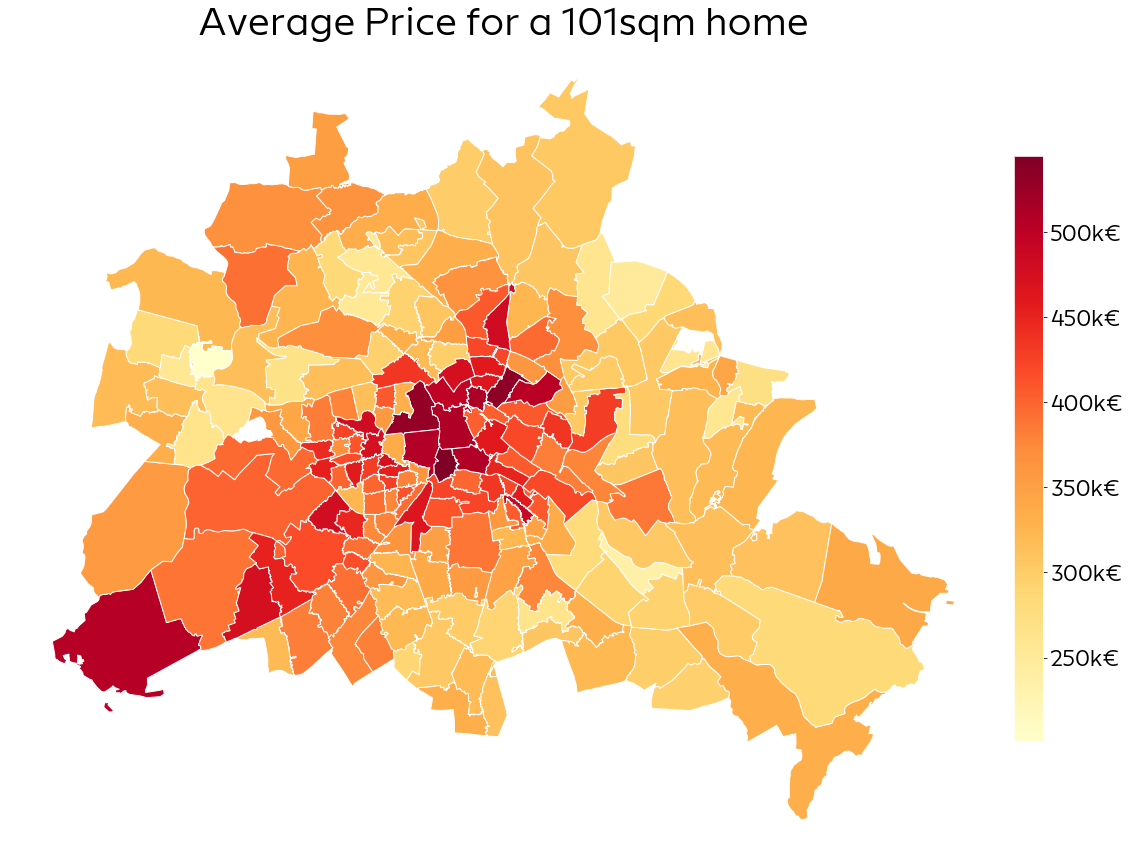

In [17]:
fig, ax = plt.subplots(figsize=(25,15))
vmin = berlin_shapes.alpha.min()
vmax = berlin_shapes.alpha.max()

ax = berlin_shapes.dropna().plot(column="alpha", ax=ax, edgecolor="white", cmap="YlOrRd")

ax.axis("off")
sm = plt.cm.ScalarMappable(cmap="YlOrRd", norm=plt.Normalize(vmin, vmax))
sm._A = []
cbar = fig.colorbar(sm, ax=ax, spacing="proportional", format=StrMethodFormatter("{x:.0f}k€"), 
                     fraction=0.021, pad=0.01)
cbar.outline.set_edgecolor("white")
cbar.ax.tick_params(labelsize=22)
ax.set_title("Average Price for a 101sqm home", fontsize=38)
plt.show()

In [18]:
more_houses = pd.DataFrame({"area": standardize_area(np.array([100]*num_zip_codes), d=d), "zip_code": zip_codes})

In [19]:
more_houses["zip"] = map_zip_codes(more_houses["zip_code"])

In [20]:
with centered_hier_model:
    zips.set_value(more_houses["zip"])
    pm.set_data({"area": more_houses["area"]})
    post_pred = pm.sample_posterior_predictive(trace, samples=1000)

100%|██████████| 1000/1000 [00:01<00:00, 516.32it/s]


In [21]:
pred = xr.DataArray(post_pred["y"], dims=("samples", "zip_code"), coords={"zip_code": zip_codes})

In [22]:
pred_df = pred.groupby("zip_code").apply(lambda x: np.mean(x < 3.5)).rename("prob").to_dataframe()

In [23]:
berlin_shapes = berlin_shapes.join(pred_df, on="plz")

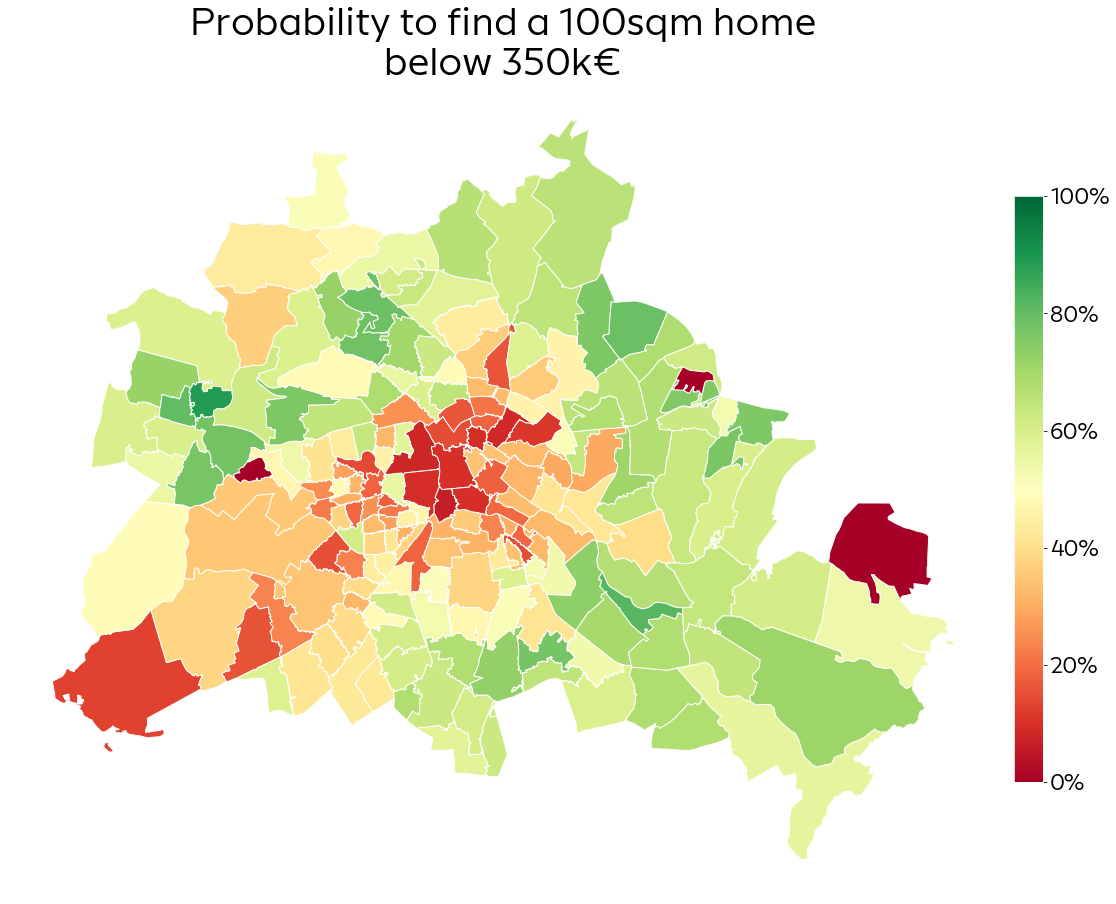

In [24]:
fig, ax = plt.subplots(figsize=(25,15))
vmin = 0
vmax = 1 

ax = berlin_shapes.plot(column="prob", ax=ax, edgecolor="white", cmap="RdYlGn",vmin=vmin, vmax=vmax)

ax.axis("off")
sm = plt.cm.ScalarMappable(cmap="RdYlGn", norm=plt.Normalize(0, 100))
sm._A = []
cbar = fig.colorbar(sm, ax=ax, spacing="proportional", format=PercentFormatter(), 
                     fraction=0.021, pad=0.01)
cbar.outline.set_edgecolor("white")
cbar.ax.tick_params(labelsize=22)
ax.set_title("Probability to find a 100sqm home\nbelow 350k€", fontsize=38)
plt.show()